# HSE 2023: Введение в машинное обучение БИ 23/24

## ДЗ 2

# Внимание!
Если в задании просят объяснить что-либо, то это значит, что требуется письменный ответ, который является частью задания и оценивается

Мы только принимаем ipynb ноутбуки. Если вы используете Google Colab, то вам необходимо скачать ноутбук перед сдачей ДЗ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
# from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from math import sqrt
import random
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style="darkgrid")

### Данные

Для этого ДЗ мы будем использовать датасет треков со стримингового сервиса Spotify

**Описание данных**

- **track_id:** The Spotify ID for the track
- **artists:** The artists' names who performed the track. If there is more than one artist, they are separated by a ;
- **album_name:** The album name in which the track appears
- **track_name:** Name of the track
- **popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
- **duration_ms:** The track length in milliseconds
- **explicit:** Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
- **danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
- **key:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
- **loudness:** The overall loudness of a track in decibels (dB)
- **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
- **speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
- **acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
- **instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
- **liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
- **time_signature:** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
- **track_genre:** The genre in which the track belongs

**Целевая переменная**
- **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

In [2]:
data = pd.read_csv('dataset.csv')

# Посмотрим датасет на наличие в нем Nan
print(f" * Count of rows, contains Nan values: {data[data.isna().any(axis=1)].shape[0]}\n")

# Всего одна строка, просто удалим ее
data = data.dropna()

y = data['energy']
X = data.drop(['energy'], axis=1)
columns = X.columns

 * Count of rows, contains Nan values: 1



## Линейная регрессия

#### 0. [0.25 балла] Закодируйте категориальные признаки. Объясните выбранный вами метод.

### <span style="color:red">Объяснения</span>
```
Имена авторов и жанры я дропать не стал, так как они содержат полезную информацию. 
Большинство артистов пишут музыку в определенном узнаваемом стиле, потому, увидев в строке Rammstein или Depeche mode, 
можно предсказать энергетику песни. Ну с жанрами тоже самое. Я решил закодировать эти признаки с помощью target encoding, потому что 
они не является упорядоченными и содержат большое количество значений, что не очень хочется превращать в дополнительные колонки
```

In [3]:
# Найдем все категориальные признаки
categorical = list(X.dtypes[X.dtypes == "object"].index)
print(f" * Categorical: {categorical}")

# Я дропнул признаки с названиями, потому что они не несут никакой прикладной информации об энергичности трека.
X = X.drop(["album_name", "track_name"], axis=1)
categorical.remove("album_name")
categorical.remove("track_name")

print(f" * Unique values: \n\tArtists - {X['artists'].nunique()} \n\tGenres - {X['track_genre'].nunique()}")

from category_encoders import TargetEncoder

target_encoder = TargetEncoder()
X_encoded = target_encoder.fit_transform(X, y)

 * Categorical: ['artists', 'album_name', 'track_name', 'track_genre']
 * Unique values: 
	Artists - 31437 
	Genres - 114


#### 1. [0.25 балла] Разбейте данные на train и test с пропорцией 75:25 и random_state=7. 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=7)

#### 2. [0.75 балла] Обучите модели на train'е, исключив категориальные признаки, используя библиотеку StatsModels и примените ее к test'у; используйте $RMSE$ и $R ^ 2$ в качестве метрики качества. Попробуйте также применить реализации линейной регрессии из sklearn:

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.03$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.05$
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) with $\alpha = 0.01$, $l_{1}$_$ratio = 0.4$

Не забывайте скейлить данные с помощью StandardScaler перед обучением моделей! 

In [5]:
# Функция, обучающая модели
def train_on_models (X_train, X_test, y_train, y_test):
    
    # Масштабируем признаки
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
    y_train = list(y_train)
    y_test = list(y_test)

    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    models = [ 
               ("LinearRegressionModel", sm.OLS(y_train, X_train_scaled).fit(), # statsmodels
                LinearRegression().fit(X_train_scaled, y_train)), # sklearn
               ("RidgeModel\t", sm.OLS(y_train, X_train_scaled).fit_regularized(method='elastic_net', # statsmodels
                                                                                    L1_wt=0.0000001, alpha=0.03, refit=True),
                Ridge(alpha=0.03).fit(X_train_scaled, y_train)), # sklearn
               ("LassoModel\t", sm.OLS(y_train, X_train_scaled).fit_regularized(method='elastic_net', # statsmodels
                                                                                    L1_wt=1, alpha=0.05, refit=True),
                Lasso(alpha=0.05).fit(X_train_scaled, y_train)), # sklearn
               ("ElasricNetModel\t", sm.OLS(y_train, X_train_scaled).fit_regularized(method='elastic_net', # statsmodels
                                                                                    L1_wt=0.4, alpha=0.01, refit=True),
                ElasticNet(alpha=0.01, l1_ratio=0.4).fit(X_train_scaled, y_train)) # sklearn
             ]
    print(3*'\t' + "StatsModels:" + '\t' + "Sklearn:")
    
    for model in models: 
        y_pred_statsmodels = model[1].predict(X_test_scaled)
        y_pred_sklean = model[2].predict(X_test_scaled)
        
        print(f"{model[0]}", end='')
        print("\tRMSE = %.4f" % mean_squared_error(y_test, y_pred_statsmodels, squared=False), end='')
        print("\tRMSE = %.4f" % mean_squared_error(y_test, y_pred_sklean, squared=False))

    for model in models:
        y_pred_statsmodels = model[1].predict(X_test_scaled)
        y_pred_sklean = model[2].predict(X_test_scaled)
        
        print(f"{model[0]}", end='')
        print("\tR^2 = %.4f" % r2_score(y_test, y_pred_statsmodels), end='')
        print("\tR^2 = %.4f" % r2_score(y_test, y_pred_sklean))

    return models

In [6]:
# Получим все некатегориальные признаки 
X_train_wo_cat = X_train.drop(categorical, axis=1)
X_test_wo_cat = X_test.drop(categorical, axis=1)

models_wo_cat = train_on_models(X_train_wo_cat, X_test_wo_cat, y_train, y_test)

			StatsModels:	Sklearn:
LinearRegressionModel	RMSE = 0.1215	RMSE = 0.1215
RidgeModel		RMSE = 0.1215	RMSE = 0.1215
LassoModel		RMSE = 0.1367	RMSE = 0.1473
ElasricNetModel		RMSE = 0.1218	RMSE = 0.1225
LinearRegressionModel	R^2 = 0.7659	R^2 = 0.7659
RidgeModel		R^2 = 0.7659	R^2 = 0.7659
LassoModel		R^2 = 0.7041	R^2 = 0.6561
ElasricNetModel		R^2 = 0.7648	R^2 = 0.7621


#### 3. [0.25 балла] Повторите шаги из предыдущего пункта, добавив категориальные признаки. Прокомментируйте изменения значений метрик качества

### <span style="color:red">Объяснения</span>
``` 
Метрика RMSE стала меньше, а R^2 больше, что свидетельствует о повышении качества обученной модели.
В целом ожидаемо, ведь, как я раньше писал, данные категориальные признаки содержат полезную информацию
```

In [7]:
models = train_on_models(X_train, X_test, y_train, y_test)

			StatsModels:	Sklearn:
LinearRegressionModel	RMSE = 0.1123	RMSE = 0.1123
RidgeModel		RMSE = 0.1123	RMSE = 0.1123
LassoModel		RMSE = 0.1258	RMSE = 0.1374
ElasricNetModel		RMSE = 0.1156	RMSE = 0.1133
LinearRegressionModel	R^2 = 0.8002	R^2 = 0.8002
RidgeModel		R^2 = 0.8002	R^2 = 0.8002
LassoModel		R^2 = 0.7493	R^2 = 0.7009
ElasricNetModel		R^2 = 0.7881	R^2 = 0.7966


#### 4. [1 балл] Исследуйте значения параметров полученных моделей и проверьте какие веса получились нулевыми. Прокомментируйте значимость коэффициентов, обшую значимость модели и остальные факторы из результирующей таблицы 

### <span style="color:red">Объяснения</span>
```
Как мы можем наблюдать, абсолютно все параметры, кроме Key имеют pvalue равное 0, что говорит нам о 
статистической важности этих параметров для модели, кроме того, вышло так, что я выбрал удачные категориальные признаки
и выбрал удачный вариант их кодирования

Значение коэффициентов при параметрах указывают на направление влияния на модель. То есть, отрицательные значения 
параметров popularity, explicit, danceability, mode, acousticness говорят о отрицательном влиянии на результирующую
модель. Но вот что странно, я попробовал обучить модель, выбросив эти параметры, 
и метрика R-squared приняла значение 0.756, что меньше текущего, что говорит о ухудшемся качестве модели (на изображении в след ячейке)
Как я понял, дело в том, что Key стало больше влиять на модель, но ее коффициент остался очень маленьким

Можем заметить, что подобная тенденция сохраняется для всех моделей

Как я понял, nan значения p появляются когда вероятность равна 0 или 1, в нашем случае p = 0
```

In [8]:
# Linear regression 
models[0][1].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.802       
Dependent Variable: y                AIC:                -131902.0414
Date:               2023-10-23 06:20 BIC:                -131742.9850
No. Observations:   85499            Log-Likelihood:     65968.      
Df Model:           16               F-statistic:        2.169e+04   
Df Residuals:       85482            Prob (F-statistic): 0.00        
R-squared:          0.802            Scale:              0.012515    
---------------------------------------------------------------------
                     Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                0.6419   0.0004 1677.8057 0.0000  0.6412  0.6427
artists              0.0508   0.0005   94.6209 0.0000  0.0498  0.0519
popularity          -0.0029   0.0004   -7.4317 0.0000 -0.0036 -0.0021
duration_ms          0.0017   0.0004    4.2190 0.0000  0.0009  0.0024
explicit            -0.0027   0.0004   -6.4926 0.0000 -0.0035 -0.0019
danceability        -0.0269   0.0005  -57.4729 0.0000 -0.0279 -0.0260
key                  0.0004   0.0004    1.1541 0.2485 -0.0003  0.0012
loudness             0.1113   0.0006  191.7855 0.0000  0.1102  0.1125
mode                -0.0026   0.0004   -6.6334 0.0000 -0.0034 -0.0018
speechiness          0.0217   0.0004   51.8706 0.0000  0.0209  0.0225
acousticness        -0.0744   0.0006 -132.5116 0.0000 -0.0755 -0.0733
instrumentalness     0.0334   0.0005   73.8899 0.0000  0.0325  0.0343
liveness             0.0212   0.0004   52.5667 0.0000  0.0204  0.0219
valence              0.0376   0.0005   80.2445 0.0000  0.0366  0.0385
tempo                0.0056   0.0004   13.8626 0.0000  0.0048  0.0063
time_signature       0.0050   0.0004   12.5746 0.0000  0.0042  0.0058
track_genre          0.0260   0.0006   46.0216 0.0000  0.0249  0.0271
---------------------------------------------------------------------
Omnibus:             5424.939       Durbin-Watson:          1.998    
Prob(Omnibus):       0.000          Jarque-Bera (JB):       23851.079
Skew:                0.133          Prob(JB):               0.000    
Kurtosis:            5.574          Condition No.:          3        
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

<div>
<img src="results_wo_params.png" width="400"/>
</div>

In [9]:
# Ridge
models[1][1].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.802       
Dependent Variable: y                AIC:                -131900.0414
Date:               2023-10-23 06:20 BIC:                -131731.6287
No. Observations:   85499            Log-Likelihood:     65968.      
Df Model:           17               F-statistic:        2.042e+04   
Df Residuals:       85482            Prob (F-statistic): 0.00        
Method:             elastic_net      Scale:              0.012515    
R-squared:          0.802                                            
---------------------------------------------------------------------
                     Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                0.6419   0.0004 1677.8057 0.0000  0.6412  0.6427
artists              0.0508   0.0005   94.6209 0.0000  0.0498  0.0519
popularity          -0.0029   0.0004   -7.4317 0.0000 -0.0036 -0.0021
duration_ms          0.0017   0.0004    4.2190 0.0000  0.0009  0.0024
explicit            -0.0027   0.0004   -6.4926 0.0000 -0.0035 -0.0019
danceability        -0.0269   0.0005  -57.4729 0.0000 -0.0279 -0.0260
key                  0.0004   0.0004    1.1541 0.2485 -0.0003  0.0012
loudness             0.1113   0.0006  191.7855 0.0000  0.1102  0.1125
mode                -0.0026   0.0004   -6.6334 0.0000 -0.0034 -0.0018
speechiness          0.0217   0.0004   51.8706 0.0000  0.0209  0.0225
acousticness        -0.0744   0.0006 -132.5116 0.0000 -0.0755 -0.0733
instrumentalness     0.0334   0.0005   73.8899 0.0000  0.0325  0.0343
liveness             0.0212   0.0004   52.5667 0.0000  0.0204  0.0219
valence              0.0376   0.0005   80.2445 0.0000  0.0366  0.0385
tempo                0.0056   0.0004   13.8626 0.0000  0.0048  0.0063
time_signature       0.0050   0.0004   12.5746 0.0000  0.0042  0.0058
track_genre          0.0260   0.0006   46.0216 0.0000  0.0249  0.0271
---------------------------------------------------------------------
Omnibus:             5424.939       Durbin-Watson:          1.998    
Prob(Omnibus):       0.000          Jarque-Bera (JB):       23851.079
Skew:                0.133          Prob(JB):               0.000    
Kurtosis:            5.574          Condition No.:          3        
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [10]:
# Lasso
models[2][1].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.752       
Dependent Variable: y                AIC:                -112500.0136
Date:               2023-10-23 06:20 BIC:                -112453.2323
No. Observations:   85499            Log-Likelihood:     56255.      
Df Model:           4                F-statistic:        6.480e+04   
Df Residuals:       85495            Prob (F-statistic): 0.00        
Method:             elastic_net      Scale:              0.015705    
R-squared:          0.752                                            
---------------------------------------------------------------------
                     Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                0.6419   0.0004 1497.7425 0.0000  0.6411  0.6428
artists              0.0709   0.0006  127.8784 0.0000  0.0698  0.0720
popularity           0.0000   0.0000       nan    nan  0.0000  0.0000
duration_ms          0.0000   0.0000       nan    nan  0.0000  0.0000
explicit             0.0000   0.0000       nan    nan  0.0000  0.0000
danceability         0.0000   0.0000       nan    nan  0.0000  0.0000
key                  0.0000   0.0000       nan    nan  0.0000  0.0000
loudness             0.1044   0.0006  186.7080 0.0000  0.1033  0.1055
mode                 0.0000   0.0000       nan    nan  0.0000  0.0000
speechiness          0.0000   0.0000       nan    nan  0.0000  0.0000
acousticness        -0.0821   0.0006 -143.5493 0.0000 -0.0833 -0.0810
instrumentalness     0.0000   0.0000       nan    nan  0.0000  0.0000
liveness             0.0000   0.0000       nan    nan  0.0000  0.0000
valence              0.0000   0.0000       nan    nan  0.0000  0.0000
tempo                0.0000   0.0000       nan    nan  0.0000  0.0000
time_signature       0.0000   0.0000       nan    nan  0.0000  0.0000
track_genre          0.0000   0.0000       nan    nan  0.0000  0.0000
---------------------------------------------------------------------
Omnibus:             4212.831       Durbin-Watson:          1.997    
Prob(Omnibus):       0.000          Jarque-Bera (JB):       11879.118
Skew:                0.239          Prob(JB):               0.000    
Kurtosis:            4.762          Condition No.:          3        
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [11]:
# ElasricNet
models[3][1].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.790       
Dependent Variable: y                AIC:                -126585.0528
Date:               2023-10-23 06:20 BIC:                -126482.1339
No. Observations:   85499            Log-Likelihood:     63304.      
Df Model:           10               F-statistic:        3.210e+04   
Df Residuals:       85489            Prob (F-statistic): 0.00        
Method:             elastic_net      Scale:              0.013319    
R-squared:          0.790                                            
---------------------------------------------------------------------
                     Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                0.6419   0.0004 1626.3914 0.0000  0.6411  0.6427
artists              0.0626   0.0005  121.0446 0.0000  0.0615  0.0636
popularity          -0.0044   0.0004  -10.9294 0.0000 -0.0051 -0.0036
duration_ms          0.0000   0.0000       nan    nan  0.0000  0.0000
explicit             0.0000   0.0000       nan    nan  0.0000  0.0000
danceability         0.0000   0.0000       nan    nan  0.0000  0.0000
key                  0.0000   0.0000       nan    nan  0.0000  0.0000
loudness             0.1124   0.0006  192.9112 0.0000  0.1113  0.1135
mode                 0.0000   0.0000       nan    nan  0.0000  0.0000
speechiness          0.0191   0.0004   46.9316 0.0000  0.0183  0.0199
acousticness        -0.0804   0.0005 -148.7908 0.0000 -0.0815 -0.0794
instrumentalness     0.0338   0.0005   72.9604 0.0000  0.0329  0.0347
liveness             0.0261   0.0004   64.2627 0.0000  0.0253  0.0269
valence              0.0250   0.0004   58.8128 0.0000  0.0241  0.0258
tempo                0.0101   0.0004   24.7592 0.0000  0.0093  0.0109
time_signature       0.0000   0.0000       nan    nan  0.0000  0.0000
track_genre          0.0000   0.0000       nan    nan  0.0000  0.0000
---------------------------------------------------------------------
Omnibus:             4400.795       Durbin-Watson:          1.996    
Prob(Omnibus):       0.000          Jarque-Bera (JB):       16699.588
Skew:                0.085          Prob(JB):               0.000    
Kurtosis:            5.158          Condition No.:          3        
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

#### 5. [1 балл] Реализуйте один из алгоритмов отбора признаков (Elimination by P-value, Forward elimination, Backward elimination), сделайте выводы.

### <span style="color:red">Объяснения</span>
```
Для проверки алгоритма Backward elimination я закинул в функцию исходные данные, со всеми признаками, закодированными target encode,
чтобы проверить качество обученной модели, если дать модели самой решить какие признаки нужны, а какие, напротив, мешают

Так же, для проверки работоспособности алгоритма я закинул в него максимальное значение p = 0, хотя на практике я бы выбрал p = 0.05

Пусть метрика r^2 adj осталась неизменной, зато мы избавились от переменных, которые не влияли на результат,
а значит облегчили модель

Но, по сути, если бы у нас были явно плохие параметры, имеющие очень большое p, то удаление данного параметра явно оказало бы на модель положительный эффект

```

In [12]:
def backward_elimination (X, y, max_p_value):
    scaler = StandardScaler()
    X_train_scaled = sm.add_constant(pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns))
    y_train = list(y)
    
    model = sm.OLS(y_train, X_train_scaled).fit()
    print(f"Before - r^2 adj = {model.rsquared_adj}\n")
    print(model.pvalues)
    
    while (max(model.pvalues) > max_p_value):
        params_w_p_greater_than_given = model.pvalues[model.pvalues == max(model.pvalues)].keys()
        X_train_scaled = X_train_scaled.drop(params_w_p_greater_than_given, axis=1)

        model = sm.OLS(y_train, X_train_scaled).fit()

    return model

In [13]:
y_tmp = data['energy']
X_tmp = data.drop(['energy'], axis=1)
target_encoder = TargetEncoder()
X_encoded_tmp = target_encoder.fit_transform(X_tmp, y_tmp)

In [14]:
pvalue = 0
# Тут для проверки реализации я задал значение p равное 0, но по факту оптимальным будет 0.05

result_model = backward_elimination(X_encoded_tmp, y_tmp, pvalue)

print(f"\nAfter - r^2 adj = {result_model.rsquared_adj}\n")
result_model.pvalues

Before - r^2 adj = 0.8534447110006806

const                0.000000e+00
artists             1.915545e-263
album_name           0.000000e+00
track_name           0.000000e+00
popularity           8.719158e-04
duration_ms          5.288067e-03
explicit             1.030235e-13
danceability         0.000000e+00
key                  2.268750e-04
loudness             0.000000e+00
mode                 2.459871e-02
speechiness          0.000000e+00
acousticness         0.000000e+00
instrumentalness     0.000000e+00
liveness             0.000000e+00
valence              0.000000e+00
tempo                9.145288e-36
time_signature       4.227223e-34
track_genre          0.000000e+00
dtype: float64

After - r^2 adj = 0.8513892068505113



const               0.0
album_name          0.0
track_name          0.0
danceability        0.0
loudness            0.0
speechiness         0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
valence             0.0
track_genre         0.0
dtype: float64

#### 6. [1 балл] Найдите лучший (по RMSE) $\alpha$ для регрессиии Lasso, используя кросс-валидацию на 5 фолдов. Вы должны выбрать значение из промежутка $[10^{-4}, 10^{3}]$.

In [15]:
scaler = StandardScaler()
X_encoded_scaled = sm.add_constant(pd.DataFrame(data=scaler.fit_transform(X_encoded), columns=X_encoded.columns))

alphas = np.logspace(-4, 3, num=8)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_mean_squared_error", cv=5)
searcher.fit(X_encoded_scaled, y) # Данные, не разделенные на train/test
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 0.0001


## Градиентный спуск

#### 7. [3.5 балла] Имплементируйте  Ridge регрессию для MSE loss, обученную на градиентом спуске.


Все вычисления должны быть векторизованы, а циклы Python можно использовать только для итераций градиентного спуска. В качестве критерия остановки необходимо использовать (одновременно):

* проверка абсолютной нормы разницы весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, заданного параметром `tolerance`);

* достижение максимального количества итераций (например, 10000, заданного параметром `max_iter`).

Вам необходимо выполнить:

* Полный градиентный спуск:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Стохастический градиентный спуск:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ является оценкой градиента по набору объектов, выбранных случайным образом.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$

* Adagrad method:

$$
G_0 = 0, \\
G_{k + 1} = G_{k} + (\nabla_{w} Q(w_{k+1}))^2, \\
w_{k + 1} = w_{k} - \eta * \frac{\nabla_{w} Q(w_{k+1})}{\sqrt{G_{k+1} + \epsilon}}.
$$

Чтобы убедиться, что процесс оптимизации действительно выполняется, мы будем использовать атрибут класса `loss_history`. После вызова метода fit он должен содержать значения функции потерь для всех итераций, начиная с первой (до первого шага по антиградиенту).


Вам нужно инициализировать веса случайным вектором из нормального распределения. Ниже приведен шаблон, который должен содержать код, реализующий все варианты моделей.

In [16]:
from sklearn.base import BaseEstimator

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3, reg_coef=0.4, epsilon=1e-6):
        """
        gd_type: str
            'GradientDescent', 'StochasticDescent', 'Momentum', 'Adagrad'
        delta: float
            proportion of object in a batch (for stochastic GD)
        tolerance: float
            for stopping gradient descent
        max_iter: int
            maximum number of steps in gradient descent
        w0: np.array of shape (d)
            init weights
        eta: float
            learning rate
        alpha: float
            momentum coefficient
        reg_cf: float
            regularization coefficient
        epsilon: float
            numerical stability
        """
        
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.reg_coef = reg_coef
        self.epsilon = epsilon
        
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        def stop_condition(current_iter, last_w):
            norm = np.linalg.norm(self.w - last_w)
            return current_iter < self.max_iter and norm > self.tolerance or current_iter == 0
                         
        if self.w0 is None:
            self.w0 = np.random.normal(size=X.shape[1])

        self.w = last_w = self.w0.copy()
        self.loss_history = []
        current_iter = 0 
        
        if self.gd_type == "GradientDescent":
            while stop_condition(current_iter, last_w):
                current_iter += 1
                last_w = self.w.copy()
                
                gradient = self.calc_gradient(X, y)
                
                self.w -= self.eta * gradient
                
                self.loss_history.append(self.calc_loss(X, y))
            
        elif self.gd_type == "StochasticDescent":
            while stop_condition(current_iter, last_w):
                current_iter += 1
                last_w = self.w.copy()
                
                batch = np.random.choice(y.shape[0], int(self.delta * y.shape[0]))
                
                gradient = self.calc_gradient(X.iloc[batch], y.iloc[batch])
                
                self.w -= self.eta * gradient
                
                self.loss_history.append(self.calc_loss(X, y))
                 
        elif self.gd_type == 'Momentum':
            h = 0 
            while stop_condition(current_iter, last_w):
                current_iter += 1
                last_w = self.w.copy()
                
                gradient = self.calc_gradient(X, y)
                h = h * self.alpha + self.eta * gradient
                
                self.w -= h
                
                self.loss_history.append(self.calc_loss(X, y))
                
        elif self.gd_type == "Adagrad":
            G = 0
            while stop_condition(current_iter, last_w):
                current_iter += 1
                last_w = self.w.copy()            
                
                gradient = self.calc_gradient(X, y)
                G += gradient**2
                self.w -= (self.eta * gradient) / np.sqrt(G + self.epsilon)
                
                self.loss_history.append(self.calc_loss(X, y))

        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        return X.dot(self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        return 2 * (np.dot(-X.T, (y.values.flatten() - X.dot(self.w))) + self.w.dot(self.reg_coef)) / y.shape[0]           
                    
    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return np.dot(X.dot(self.w) - y.values.flatten().T, (X.dot(self.w) - y.values)) / y.shape[0]

#### 8. [1 балл] Натренируйте и провалидируйте "ручные" модели на тех же даннных, сравните качество с моделями из Sklearn и StatsModels. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Соответствует ли оно вашим ожиданиям?

In [17]:
X_train_scaled = sm.add_constant(pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns))
X_test_scaled = sm.add_constant(pd.DataFrame(data=scaler.fit_transform(X_test), columns=X_test.columns))

In [18]:
basic_grad = LinReg(gd_type="GradientDescent", delta=0.5).fit(X_train_scaled, y_train)
y_pred = basic_grad.predict(X_test_scaled)

print(mean_squared_error(y_pred, y_test, squared=False))
print(r2_score(y_test, y_pred))

0.1125694525965539
0.7991943152759603


In [19]:
stochastic_grad = LinReg(gd_type="StochasticDescent", delta=0.5).fit(X_train_scaled, y_train)
y_pred = stochastic_grad.predict(X_test_scaled)

print(mean_squared_error(y_pred, y_test, squared=False))
print(r2_score(y_test, y_pred))

0.11264628983361988
0.798920091327975


In [50]:
alphas = np.logspace(-4, 3, num=8)
searcher = GridSearchCV(LinReg(gd_type="Momentum", delta=0.5), [{"alpha": alphas}], scoring="neg_mean_squared_error", cv=5)
searcher.fit(X_train_scaled, y_train)
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 0.1000


In [52]:
momentum_grad = LinReg(gd_type="Momentum", delta=0.5, alpha=best_alpha).fit(X_train_scaled, y_train)
y_pred = momentum_grad.predict(X_test_scaled)

print(mean_squared_error(y_pred, y_test, squared=False))
print(r2_score(y_test, y_pred))

0.11253928247372062
0.7993019380844024


In [38]:
adagrad_grad = LinReg(gd_type="Adagrad", delta=0.5).fit(X_train_scaled, y_train)
y_pred = adagrad_grad.predict(X_test_scaled)

print(mean_squared_error(y_pred, y_test, squared=False))
print(r2_score(y_test, y_pred))

2.357465966424735
-87.0695461817522


In [44]:
adagrad_grad_25k_iters_omg = LinReg(gd_type="Adagrad", delta=0.5, max_iter=25000, tolerance=1e-6).fit(X_train_scaled, y_train)
y_pred = adagrad_grad.predict(X_test_scaled)

print(mean_squared_error(y_pred, y_test, squared=False))
print(r2_score(y_test, y_pred))

2.357465966424735
-87.0695461817522


### <span style="color:red">Комментарии</span>
```
Ну в целом, ничего особо удивительного, написанная модель работает так же как и аналоги из sklearn и statsmodels, если судить по функции потерь и метрике r^2. Кроме того, я решил протестировать значение max_iter на самой долгой в плане обучения модели - Adargar, правда мы и смогли получить лишь 0.01 улучшения метрики r^2, что непозволительно мало, если брать в расчет количество операций, потраченных на такое незначительное улучшение, кроме того, данное улучшение модели оооочень медленно приближалось к гиперпараметру tolerance. Вот это было для меня неожиданностью. Мне не хватило 25000 операций, чтобы приблизится к значению 10^-6.
По поводу значения aplha, я предполагал, что число должно находиться где-то в районе 0.1..1, потому что 1 - слишком много, а при приближении к 0 очень долго бы происходило обучение, но по факту вышло предполагаемое мной значение
```

#### 9. [1 балл] Постройте графики (там же) зависимости значения функции потерь от номера итерации для всех моделей (полного градиентого спуска, стохастического гс, Momentum и Adagrad). Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.


Не забывайте о том, как должен выглядеть *красивый* график!

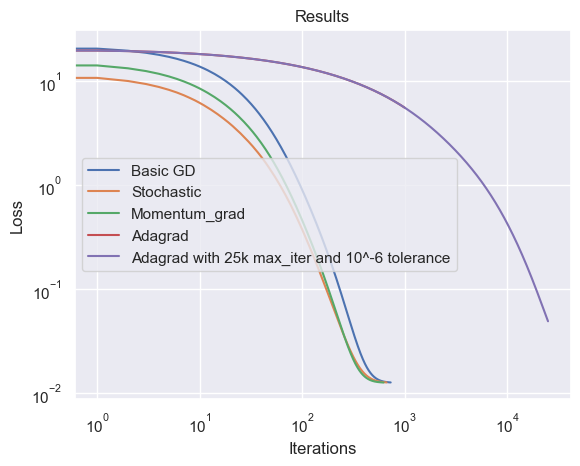

In [55]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import EventCollection

# Fixing random state for reproducibility
np.random.seed(19680801)

# create random data
xdata = np.random.random([2, 10])

# split the data into two parts
xdata1 = xdata[0, :]
xdata2 = xdata[1, :]

# sort the data so it makes clean curves
xdata1.sort()
xdata2.sort()

# create some y data points
ydata1 = xdata1 ** 2
ydata2 = 1 - xdata2 ** 3

# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(range((len(basic_grad.loss_history))), basic_grad.loss_history, label = "Basic GD")
ax.plot(range(len(stochastic_grad.loss_history)), stochastic_grad.loss_history, label = "Stochastic")
ax.plot(range(len(momentum_grad.loss_history)), momentum_grad.loss_history, label = "Momentum_grad")
ax.plot(range(len(adagrad_grad.loss_history)), adagrad_grad.loss_history, label = "Adagrad")
ax.plot(range(len(adagrad_grad_25k_values_omg.loss_history)), adagrad_grad_25k_values_omg.loss_history, 
        label = "Adagrad with 25k max_iter and 10^-6 tolerance")

ax.set_title('Results')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")

plt.legend()

# display the plot
plt.show()

### <span style="color:red">Выводы</span>
```
Судя по графику, наибыстрейшим схождением обладает стохастический спуск, а худшим из представленных вышел Agarad. Все модели сходятся в целом одинаково, если не брать во внимание последний упомянутый. Думаю, это из-за очень маленьких шагов, которые выполняет эта модификация
```